In [3]:
from gs_quant.session import GsSession
# external users should substitute their client id and secret; please skip this step if using internal jupyterhub
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics',)) 

#### Combined IR and Vol Shock

In this screen, we look at how the price fo a swaption changes under a range of spot and vol rate shocks.

In [32]:
from gs_quant.instrument import IRSwaption
from gs_quant.common import PayReceive
from gs_quant.markets.portfolio import Portfolio
from gs_quant.markets import PricingContext
from gs_quant.risk import MarketDataShockBasedScenario, MarketDataPattern, MarketDataShock, MarketDataShockType, Price
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def IR_scenario_grid(ccy, IR_min=-200, IR_max=200, IR_iter=50, vol_min=-10, vol_max=10, vol_iter=2):
    portfolio = Portfolio(IRSwaption(pay_or_receive=pay_rec, notional_currency=ccy, termination_date=termination, expiration_date=expiry, strike=f'ATMF+{moneyness}'))
    portfolio.resolve()

    IR_shocks = list(range(IR_min, IR_max + IR_iter, IR_iter))
    IR_vol_shocks = list(range(vol_min, vol_max + vol_iter, vol_iter))
    ir_vol_grid  = pd.DataFrame(index = IR_vol_shocks, columns = IR_shocks)
    grid = {}

    base_price = portfolio.price().to_frame()

    with PricingContext(is_batch=True, is_async=True):
        for IR_shock in IR_shocks:
            vals = []
            for IR_vol_shock in IR_vol_shocks:
                shocks = MarketDataShockBasedScenario(shocks={
                    MarketDataPattern('IR', ccy) : MarketDataShock(shock_type=MarketDataShockType.Absolute, value= IR_shock/10000),
                    MarketDataPattern('IR Vol'): MarketDataShock(MarketDataShockType.Absolute, IR_vol_shock/10000)
                })

                with shocks:
                    shock_price = portfolio.price()
                vals.append(shock_price)
            grid[IR_shock] = vals

    for k,v in grid.items():
        ir_vol_grid[k] = pd.DataFrame(v, index=IR_vol_shocks)
    result = 100*(ir_vol_grid/base_price[Price][0] -1)
    plt.subplots(figsize=(12, 6))
    ax = sns.heatmap(result.astype(float), annot=True, fmt='.2f', cmap='coolwarm')
    ax.set(ylabel='IR shocks (bps)', xlabel='IR Vol shocks (bps)', title=' Scenario Analysis: PV effect of IR and IR Vol shocks, %')
    ax.xaxis.tick_top()
    return result

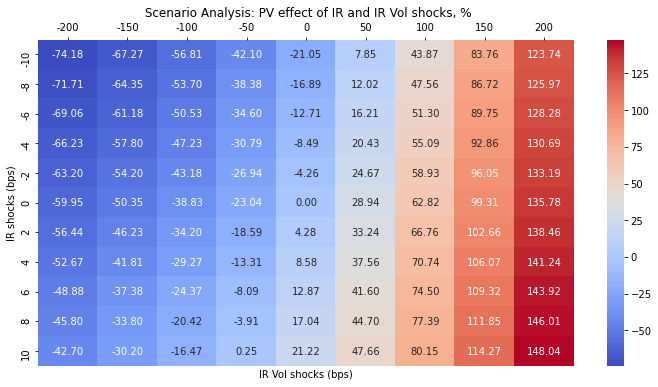

In [33]:
expiry = '10y'
termination = '10y'
pay_rec = 'Pay'
ccy = 'USD'
horizon = '0b'
moneyness = 50

#Specify shocks
IR_min = -200
IR_max = 200
IR_iter = 50
vol_min = -10
vol_max = 10
vol_iter = 2

result = IR_scenario_grid(ccy, IR_min, IR_max, IR_iter, vol_min, vol_max, vol_iter)